In [3]:
#this is all copied from https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from torchvision.utils import save_image
import torch
import torchvision

import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn = models.vgg19(pretrained=True).features.to(device).eval()

style 0


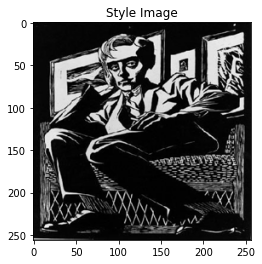

style 1


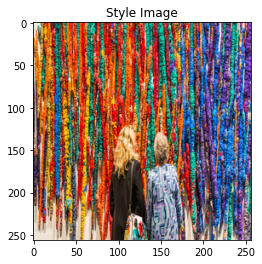

style 2


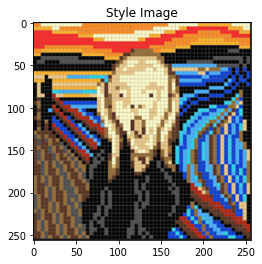

style 3


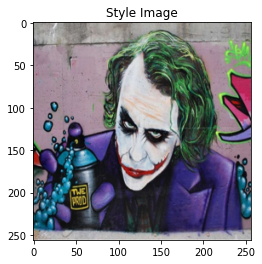

style 4


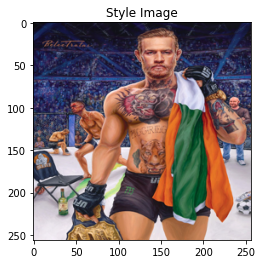

style 5


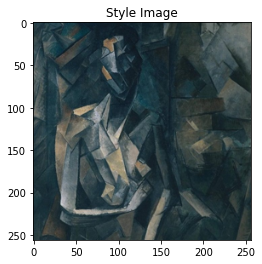

style 6


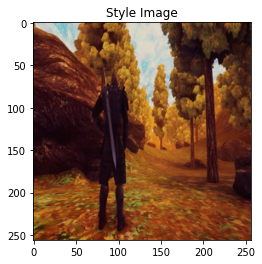

style 7


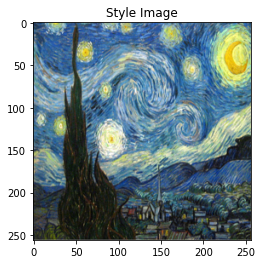

style 8


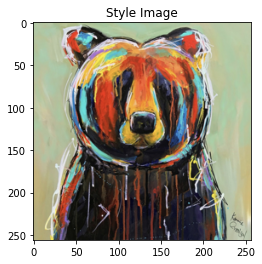

style 9


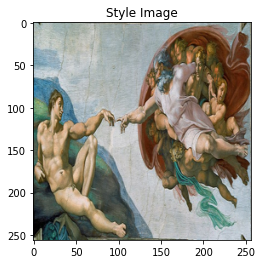

style 10


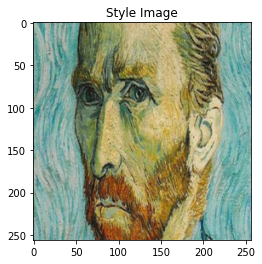

In [4]:

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 256  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image):
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

styleimage0=Image.open("images/escher1.jpeg")  
styleimage1=Image.open("images/textile1.jpeg")
styleimage2=Image.open("images/pixelart.jpeg")
styleimage3=Image.open("images/joker.jpeg") 

styleimage4=Image.open("images/conorpainting.jpeg")  
styleimage5=Image.open("images/picasso.jpeg")  
styleimage6=Image.open("images/paintedoblivion.webp")
styleimage7=Image.open("images/starrynight.jpeg")
styleimage8=Image.open("images/bear.jpeg")
styleimage9=Image.open("images/god.jpeg")
styleimage10=Image.open("images/vangogh.jpeg")  

thresh={}
thresh[0] = 560 #escher1 
thresh[1] = 140 #textile1
thresh[2]=900
thresh[3]=120 
thresh[4]=150 
thresh[5]=150 
thresh[6]=150 
thresh[7]=150 
thresh[8]=150 
thresh[9]=100 
thresh[10]=80


styleimage0=styleimage0.resize((256,256))
styleimage1=styleimage1.resize((256,256))
styleimage2=styleimage2.resize((256,256))
styleimage3=styleimage3.resize((256,256))
styleimage4=styleimage4.resize((256,256))
styleimage5=styleimage5.resize((256,256))
styleimage6=styleimage6.resize((256,256))
styleimage7=styleimage7.resize((256,256))
styleimage8=styleimage8.resize((256,256))
styleimage9=styleimage9.resize((256,256))
styleimage10=styleimage10.resize((256,256))



fighterimage=Image.open("images/2KhamzatChimaev.jpg")
fighterimage=fighterimage.resize((256,256))

style = [image_loader(styleimage0),image_loader(styleimage1),image_loader(styleimage2),
         image_loader(styleimage3), image_loader(styleimage4), image_loader(styleimage5), 
         image_loader(styleimage6), image_loader(styleimage7), image_loader(styleimage8),
        image_loader(styleimage9), image_loader(styleimage10)]

content_img = image_loader(fighterimage)
assert all(style[i].size() == content_img.size() for i in range(len(style))), \
    "we need to import style and content images of the same size"

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std
    
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()

for i in range(len(style)):
    print('style '+str(i))
    imshow(style[i], title='Style Image')

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)
    optimizer = get_input_optimizer(input_img)
    run = [0]
    while run[0] <= num_steps:
        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            style_score *= style_weight
            content_score *= content_weight
            loss = style_score + content_score
            loss.backward()
            run[0] += 1
            if run[0] ==50:
                print('Style Loss : {:4f}'.format(style_score.item()))
            return style_score + content_score
        optimizer.step(closure)
    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)
    return input_img

def run_style_transfer_adaptive(cnn, normalization_mean, normalization_std,
                       content_img, styleindex, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    style_img=style[styleindex]
    firstLoss={0:0}
    """Run the style transfer."""
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)
    optimizer = get_input_optimizer(input_img)
    run = [0]
    while run[0] <= num_steps and firstLoss[0]==0:
        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            style_score *= style_weight
            content_score *= content_weight
            loss = style_score + content_score
            loss.backward()
            run[0] += 1
            if run[0] % 50 == 0:
                if style_score.item()>thresh[styleindex]:
                    firstLoss[0]=style_score.item()
            return style_score + content_score
        optimizer.step(closure)
    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)
    if firstLoss[0]==0:
        return input_img
    else:
        return 'empty'

In [5]:
ufcfighterscrap =pd.read_csv('fighter_stats.csv',sep=',',low_memory=False)
names = list(ufcfighterscrap['name'])

In [4]:
#to test the most recently added style image
def apply_style(image, styleindex):
    fighterimage=Image.open(image);fighterimage
    fighterimage=fighterimage.resize((256,256))
    content_img = image_loader(fighterimage)
    input_img = content_img.clone()
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                content_img, style[styleindex], input_img)

    plt.figure()
    imshow(output, title='Output Image')

    # sphinx_gallery_thumbnail_number = 4
    plt.ioff()
    plt.show()

Building the style transfer model..


/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_39932/2800721741.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_39932/2800721741.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 3295.729980 Content Loss: 72.827621


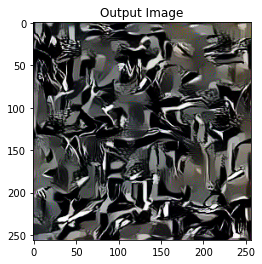

In [17]:
apply_style("images/1ColbyCovington.jpg",0)

style 0


/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_39932/28225948.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_39932/28225948.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Style Loss : 435.363220


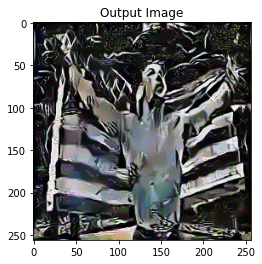

style 0
Style Loss : 3242.106201


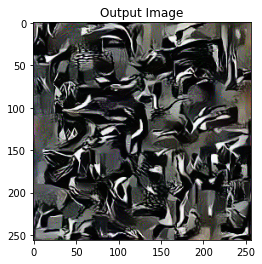

style 0
Style Loss : 550.582031


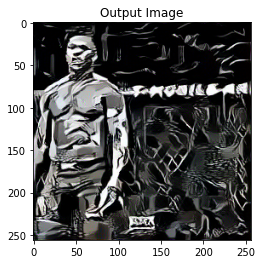

style 0
Style Loss : 3413.404785


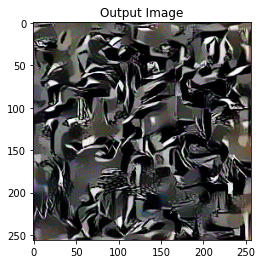

style 1
Style Loss : 1106.366089


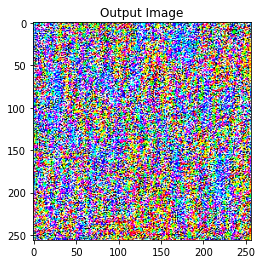

style 1
Style Loss : 981.641235


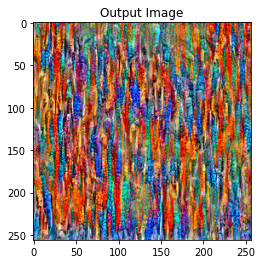

style 1
Style Loss : 1035.389893


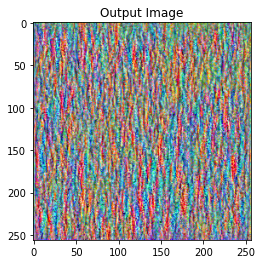

style 1
Style Loss : 1082.890625


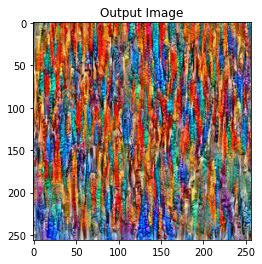

style 2
Style Loss : 698.582520


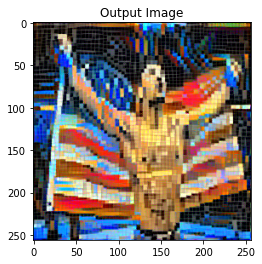

style 2
Style Loss : 1290.539062


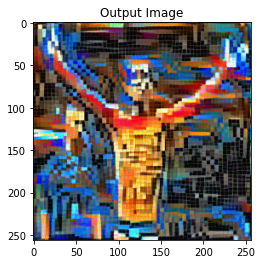

style 2
Style Loss : 2068.389160


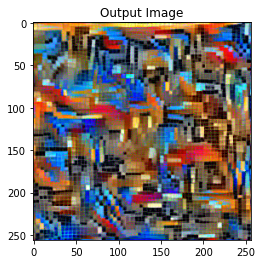

style 2
Style Loss : 1652.470093


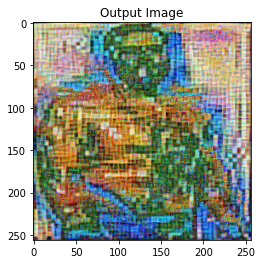

style 3
Style Loss : 94.108894


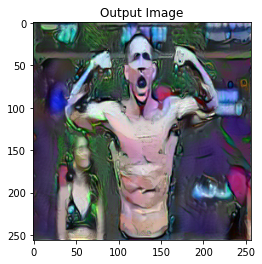

style 3
Style Loss : 115.198692


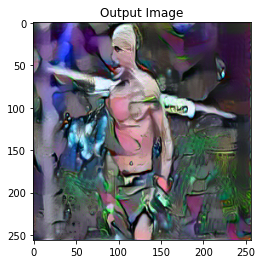

style 3
Style Loss : 153.619156


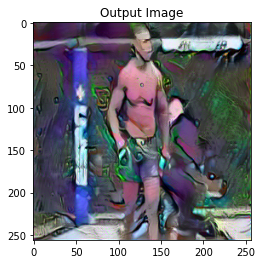

style 3
Style Loss : 236.177124


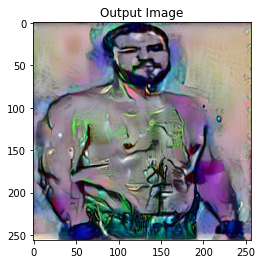

In [45]:
#testing styles
for j in range(4):
    for name in ['MichaelChandler','CharlesOliveira','FrancisNgannou','TaiTuivasa']:
        i=random.randint(1,4)
        print('style '+str(j))
        apply_style("images/"+str(i)+name+".jpg",j)
        


In [ ]:
#trying parallel with original notebook
#started at 2:23 am friday april 8
i=319
for name in names[320:801]:
    i+=1
    for j in range(1,5):
        try:
            name = name.replace(" ","")
            fighterimage=Image.open("images/"+str(j)+name+".jpg")
            fighterimage=fighterimage.resize((256,256))
            content_img = image_loader(fighterimage)
            styleindex=random.randint(1,len(style))-1
            output = 'empty'
            k=0
            while output =='empty':
                if k>len(style):
                    print(str(j)+' couldnt find a good style for '+str(j)+name)
                    break
                k+=1
                input_img = content_img.clone()
                styleindex=(styleindex+1)%len(style)
                output = run_style_transfer_adaptive(cnn, cnn_normalization_mean, cnn_normalization_std,
                                   content_img, styleindex, input_img, num_steps=300,
                                   style_weight=1000000, content_weight=1)
            img1 = output
            save_image(img1, "images2/"+str(j)+name+".jpg")
            print(str(i)+' saving: '+"images2/"+str(j)+name+".jpg"+' in style '+str(styleindex))
        except:
            print('exception')
            continue

/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_1369/2228601904.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_1369/2228601904.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


320 saving: images2/1JessicaAndrade.jpg in style 9
320 saving: images2/2JessicaAndrade.jpg in style 3
320 saving: images2/3JessicaAndrade.jpg in style 5
320 saving: images2/4JessicaAndrade.jpg in style 0
321 saving: images2/1AmandaRibas.jpg in style 4
321 saving: images2/2AmandaRibas.jpg in style 7
321 saving: images2/3AmandaRibas.jpg in style 5
321 saving: images2/4AmandaRibas.jpg in style 5
322 saving: images2/1PaigeVanZant.jpg in style 7
322 saving: images2/2PaigeVanZant.jpg in style 10
322 saving: images2/3PaigeVanZant.jpg in style 5
322 saving: images2/4PaigeVanZant.jpg in style 6
323 saving: images2/1JiriProchazka.jpg in style 8
323 saving: images2/2JiriProchazka.jpg in style 9
323 saving: images2/3JiriProchazka.jpg in style 10
323 saving: images2/4JiriProchazka.jpg in style 3
1 couldnt find a good style for 1VolkanOezdemir
exception
324 saving: images2/2VolkanOezdemir.jpg in style 3
324 saving: images2/3VolkanOezdemir.jpg in style 8
324 saving: images2/4VolkanOezdemir.jpg in sty

361 saving: images2/4RaquelPennington.jpg in style 5
362 saving: images2/1MarionReneau.jpg in style 5
362 saving: images2/2MarionReneau.jpg in style 4
3 couldnt find a good style for 3MarionReneau
exception
362 saving: images2/4MarionReneau.jpg in style 9
363 saving: images2/1BelalMuhammad.jpg in style 6
363 saving: images2/2BelalMuhammad.jpg in style 0
363 saving: images2/3BelalMuhammad.jpg in style 3
363 saving: images2/4BelalMuhammad.jpg in style 8
364 saving: images2/1LymanGood.jpg in style 5
364 saving: images2/2LymanGood.jpg in style 9
364 saving: images2/3LymanGood.jpg in style 4
364 saving: images2/4LymanGood.jpg in style 5
365 saving: images2/1RooseveltRoberts.jpg in style 4
365 saving: images2/2RooseveltRoberts.jpg in style 8
365 saving: images2/3RooseveltRoberts.jpg in style 3
365 saving: images2/4RooseveltRoberts.jpg in style 8
366 saving: images2/1ClayGuida.jpg in style 4
366 saving: images2/2ClayGuida.jpg in style 7
366 saving: images2/3ClayGuida.jpg in style 3
366 saving

In [ ]:
# 370(2) at 9:27am friday
# 2:23am-9:27am (7 hours and 4 minutes = 424 minutes)
# 320 - 370 = 50 names
# 50 names in 424 minutes is .117 names per minute